<a href="https://colab.research.google.com/github/davidanagy/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [318]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

### Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [323]:
df = df.drop(df.index[df['SALE_PRICE'] < 100000].tolist(), axis=0)
df = df.drop(df.index[df['SALE_PRICE'] >= 2000000].tolist(), axis=0)

df.describe()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,13438.000000,13438.000000,0.0,13438.000000,13438.000000,13438.000000,13438.000000,13438.000000,13415.000000,13438.000000,1.343800e+04
mean,4659.352731,346.494716,NaN,10822.261944,1.159399,0.157687,1.556035,1712.694300,1835.611554,1.582378,7.153811e+05
std,3730.856887,610.201395,NaN,1031.909147,3.366552,1.589691,5.869886,7678.609751,461.860922,0.699158,4.073546e+05
min,1.000000,1.000000,NaN,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+05
25%,1458.000000,20.250000,NaN,10310.000000,0.000000,0.000000,0.000000,0.000000,1922.500000,1.000000,4.120000e+05
50%,3900.000000,49.000000,NaN,11213.000000,1.000000,0.000000,1.000000,1124.000000,1945.000000,2.000000,6.307655e+05
75%,6826.000000,360.000000,NaN,11365.000000,2.000000,0.000000,2.000000,1863.750000,1965.000000,2.000000,9.150000e+05
max,16350.000000,9002.000000,NaN,11697.000000,155.000000,60.000000,156.000000,322160.000000,2018.000000,4.000000,1.999877e+06


In [324]:
print(df.shape)
df.head()

(13438, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
66,1,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,01/02/2019
67,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,01/02/2019
71,1,UPPER WEST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1171,2200,NaN,R4,"240 RIVERSIDE BOULEVARD, 4 F",4 F,10069.0,1.0,0.0,1.0,0,827.0,2004.0,2,R4,1250000,01/02/2019


In [325]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [326]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [327]:
train = df[df['SALE_DATE'].dt.month < 4]
test = df[df['SALE_DATE'].dt.month == 4]
print(test.shape)
test.head()

(2975, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18167,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,695,1562,NaN,R4,"555 WEST 23RD STREET, N11E",N11E,10011.0,1.0,0.0,1.0,0,670.0,2005.0,2,R4,949000,2019-04-01
18170,1,OTHER,17 CONDO COOPS,2,721,1008,NaN,R9,"465 WEST 23RD STREET, RCU1",NaN,10011.0,0.0,0.0,0.0,0,0.0,1932.0,2,R9,1100000,2019-04-01
18173,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,31,1050,NaN,R4,"75 WALL STREET, 21I",21I,10005.0,1.0,0.0,1.0,0,438.0,1987.0,2,R4,675000,2019-04-01
18174,1,GRAMERCY,10 COOPS - ELEVATOR APARTMENTS,2,880,42,NaN,D4,"330 THIRD AVENUE, 18K",NaN,10010.0,0.0,0.0,0.0,0,0.0,1964.0,2,D4,485000,2019-04-01
18175,1,GRAMERCY,13 CONDOS - ELEVATOR APARTMENTS,2,878,1010,NaN,R4,"121 EAST 22ND STREET, N204",N204,10010.0,1.0,0.0,1.0,"22,202",773.0,1952.0,2,R4,1486645,2019-04-01


In [0]:
assert train.shape[0] + test.shape[0] == df.shape[0]

### Do one-hot encoding of categorical features.

In [329]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
66,1,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,2019-01-02
67,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,2019-01-02
71,1,UPPER WEST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1171,2200,NaN,R4,"240 RIVERSIDE BOULEVARD, 4 F",4 F,10069.0,1.0,0.0,1.0,0,827.0,2004.0,2,R4,1250000,2019-01-02


In [330]:
import numpy as np

train.describe(exclude=np.number)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,10463,10463,10463,10463,10463,10463,2138,10438,10463,10463
unique,5,11,40,10,96,10417,826,1997,96,80
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,D4,N/A BAY STREET,2A,0,D4,2019-01-31 00:00:00
freq,3620,8856,2515,4959,2114,4,42,4067,2114,285
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [331]:
# Here I try to figure out how to get the street name by itself.

train['ADDRESS'].head()

44                4832 BAY PARKWAY
61              80-23 232ND STREET
66            345 EAST 54TH ST, 3B
67         16 EAST 80TH STREET, 2A
71    240 RIVERSIDE BOULEVARD, 4 F
Name: ADDRESS, dtype: object

In [332]:
s = '447 WEST 18TH STREET, PH12A'

a,b = s.split(' ', 1)
b

'WEST 18TH STREET, PH12A'

In [333]:
def address_to_street(address):
  if ',' in address:
    st_address, apartment = address.split(',')
  else:
    st_address = address
  number, street = st_address.split(' ', 1)
  return street

address_to_street(s)

'WEST 18TH STREET'

In [334]:
address_to_street('144 WEST 37TH STREET')

'WEST 37TH STREET'

In [335]:
# When I first tried to apply the above function to the entire column, I got an error.
# Using try/except, I discovered it was because of five rows with more than one comma.

streets = []
for i in range(len(train)):
  try:
    streets.append(address_to_street(train.iloc[i,8]))
  except:
    print(i)
streets

799
3823
5726
8076
8811


['BAY PARKWAY',
 '232ND STREET',
 'EAST 54TH ST',
 'EAST 80TH STREET',
 'RIVERSIDE BOULEVARD',
 'WEST 82ND STREET',
 'WEST 82ND STREET',
 'CHATTERTON AVENUE',
 'FORDHAM HILL OVAL',
 'RHINELANDER AVE',
 'WHEELER AVENUE',
 'ROBINSON AVE',
 'YZNAGA PLACE',
 '81ST STREET',
 'FULTON STREET',
 'FULTON STREET',
 'AVENUE T',
 'GREENE AVE',
 'PACIFIC STREET',
 'PACIFIC STREET',
 'SCHENCK AVE',
 'WYONA STREET',
 'E 25TH ST',
 'GLENWOOD ROAD',
 'WHITTY LANE',
 'HAWTHORNE STREET',
 'HAWTHORNE STREET',
 'MAPLE STREET',
 'DAHILL ROAD',
 'BAY PARKWAY',
 'BAY PARKWAY',
 'BAY PARKWAY',
 'EAST 23RD STREET',
 'EAST 15TH STREET',
 'AVENUE M',
 '43RD STREET',
 'SHORE BOULEVARD',
 '50TH AVENUE',
 '46TH AVENUE',
 '144TH STREET',
 '57 ROAD',
 '198TH STREET',
 'SANFORD AVENUE',
 'GRAND CENTRAL PARKWAY',
 'HOLLIS AVENUE',
 'WOODHULL AVENUE',
 'WOODHULL AVENUE',
 '82ND STREET',
 '164TH ROAD',
 '92ND STREET',
 '93RD STREET',
 'GRENFELL STREET',
 '230 STREET',
 '222ND STREET',
 'DELEVAN STREET',
 'SPRINGFIELD BLVD

In [336]:
def address_to_street(address):
  if ',' in address:
    st_address, apartment = address.split(',', 1)
  else:
    st_address = address
  number, street = st_address.split(' ', 1)
  return street

address_to_street(s)

'WEST 18TH STREET'

In [337]:
streets_train = []
for i in range(len(train)):
  streets_train.append(address_to_street(train.iloc[i,8]))

streets_train

['BAY PARKWAY',
 '232ND STREET',
 'EAST 54TH ST',
 'EAST 80TH STREET',
 'RIVERSIDE BOULEVARD',
 'WEST 82ND STREET',
 'WEST 82ND STREET',
 'CHATTERTON AVENUE',
 'FORDHAM HILL OVAL',
 'RHINELANDER AVE',
 'WHEELER AVENUE',
 'ROBINSON AVE',
 'YZNAGA PLACE',
 '81ST STREET',
 'FULTON STREET',
 'FULTON STREET',
 'AVENUE T',
 'GREENE AVE',
 'PACIFIC STREET',
 'PACIFIC STREET',
 'SCHENCK AVE',
 'WYONA STREET',
 'E 25TH ST',
 'GLENWOOD ROAD',
 'WHITTY LANE',
 'HAWTHORNE STREET',
 'HAWTHORNE STREET',
 'MAPLE STREET',
 'DAHILL ROAD',
 'BAY PARKWAY',
 'BAY PARKWAY',
 'BAY PARKWAY',
 'EAST 23RD STREET',
 'EAST 15TH STREET',
 'AVENUE M',
 '43RD STREET',
 'SHORE BOULEVARD',
 '50TH AVENUE',
 '46TH AVENUE',
 '144TH STREET',
 '57 ROAD',
 '198TH STREET',
 'SANFORD AVENUE',
 'GRAND CENTRAL PARKWAY',
 'HOLLIS AVENUE',
 'WOODHULL AVENUE',
 'WOODHULL AVENUE',
 '82ND STREET',
 '164TH ROAD',
 '92ND STREET',
 '93RD STREET',
 'GRENFELL STREET',
 '230 STREET',
 '222ND STREET',
 'DELEVAN STREET',
 'SPRINGFIELD BLVD

In [0]:
assert len(streets_train) == len(train)

In [339]:
train['STREET'] = np.array(streets_train)

train['STREET'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


WEST END AVENUE          66
34TH AVENUE              62
BROADWAY                 42
OCEAN PARKWAY            39
BEDFORD AVENUE           38
RIVERSIDE DRIVE          37
PARK AVENUE              33
GRAND CENTRAL PARKWAY    33
PARSONS BOULEVARD        33
OCEAN AVENUE             32
EAST 19TH STREET         27
FIFTH AVENUE             27
78TH STREET              26
72ND ROAD                25
UNION TURNPIKE           24
EAST 22ND STREET         24
CENTRAL PARK WEST        24
EAST 79TH STREET         23
EAST 73RD STREET         23
STOCKTON STREET          23
GRAND CONCOURSE          22
35TH AVENUE              22
EAST 72ND STREET         22
KENT AVENUE              22
GRAND STREET             21
EAST 87TH STREET         21
EAST 93RD STREET         21
EAST 86TH STREET         21
CLINTON AVENUE           20
THIRD AVENUE             20
                         ..
MORGAN AVE                1
SCHOOL ROAD               1
MILA WAY                  1
TOTTENVILLE PLACE         1
DECKER AVENUE       

In [340]:
# I also need to get rid of all the NaNs.

train.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  0
BLOCK                                 0
LOT                                   0
EASE-MENT                         10463
BUILDING_CLASS_AT_PRESENT             0
ADDRESS                               0
APARTMENT_NUMBER                   8325
ZIP_CODE                              0
RESIDENTIAL_UNITS                     0
COMMERCIAL_UNITS                      0
TOTAL_UNITS                           0
LAND_SQUARE_FEET                     25
GROSS_SQUARE_FEET                     0
YEAR_BUILT                            5
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
STREET                                0
dtype: int64

In [341]:
train['LAND_SQUARE_FEET'].head(20)

44     6,800
61     4,000
66         0
67         0
71         0
72         0
73         0
74     4,129
75         0
78     3,500
79     2,500
80     1,967
81     5,716
84     2,000
87     5,900
88     2,904
91     3,275
97     2,000
101        0
102        0
Name: LAND_SQUARE_FEET, dtype: object

In [342]:
# Drop the new column so I can have a fresh dataframe to apply the following function on.

train = train.drop('STREET', axis=1)
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
66,1,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,2019-01-02
67,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,2019-01-02
71,1,UPPER WEST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1171,2200,NaN,R4,"240 RIVERSIDE BOULEVARD, 4 F",4 F,10069.0,1.0,0.0,1.0,0,827.0,2004.0,2,R4,1250000,2019-01-02


In [343]:
import category_encoders as ce

def make_features(X):
  # Add my new Streets column.
  streets = [address_to_street(X.iloc[i,8]) for i in range(len(X))]
  X['STREET'] = np.array(streets)
  # Getting rid of Address and Apartment Number because I think "Streets" is a lot more useful.
  # Getting rid of Ease-ment because it's just NaNs.
  X = X.drop(['EASE-MENT', 'ADDRESS', 'APARTMENT_NUMBER'], axis=1)
  # I choose to treat NaNs in "Land Square Feet" as 0, since there are already plenty of 0 columns for some reason.
  X['LAND_SQUARE_FEET'] = X['LAND_SQUARE_FEET'].fillna(0)
  X['LAND_SQUARE_FEET'] = X['LAND_SQUARE_FEET'].str.replace(',', '')
  X['LAND_SQUARE_FEET'] = X['LAND_SQUARE_FEET'].str.replace('########', '')
  X['LAND_SQUARE_FEET'] = pd.to_numeric(X['LAND_SQUARE_FEET'])
  X = X.dropna()
  # Making the Sale_Date column into a float with descriptive values (month.day).
  X['SALE_DATE'] = (X['SALE_DATE'].dt.month + X['SALE_DATE'].dt.day/100)
  
  # For the category columns with a large number of unique values, I apply the same top 10 method
  # Ryan did at the beginning of the notebook.
  
  top10_class_present = X['BUILDING_CLASS_AT_PRESENT'].value_counts()[:10].index
  X.loc[~X['BUILDING_CLASS_AT_PRESENT'].isin(top10_class_present), 'BUILDING_CLASS_AT_PRESENT'] = 'OTHER'
  
  top10_class_sale = X['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()[:10].index
  X.loc[~X['BUILDING_CLASS_AT_TIME_OF_SALE'].isin(top10_class_sale), 'BUILDING_CLASS_AT_TIME_OF_SALE'] = 'OTHER'
  
  top50 = X['STREET'].value_counts()[:50].index
  X.loc[~X['STREET'].isin(top50), 'STREET'] = 'OTHER'
  
  encoder = ce.OneHotEncoder(use_cat_names=True)
  X = encoder.fit_transform(X)
  return X

train = make_features(train)
train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_1,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_UPPER WEST SIDE (79-96),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_FOREST HILLS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING_CLASS_CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_44 CONDO PARKING,BUILDING_CLASS_CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING_CLASS_CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING_CLASS_CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING_CLASS_CATEGORY_17 CONDO COOPS,BUILDING_CLASS_CATEGORY_29 COMMERCIAL GARAGES,BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING_CLASS_CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_27 FACTORIES,BUILDING_CLASS_CATEGORY_22 STORE BUILDINGS,BUILDING_CLASS_CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING_CLASS_CATEGORY_45 CONDO HOTELS,BUILDING_CLASS_CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING_CLASS_CATEGORY_14 RENTALS - 4-10 UNIT,...,STREET_UNION STREET,STREET_JUNCTION BOULEVARD,STREET_72ND ROAD,STREET_UNION TURNPIKE,STREET_84TH STREET,STREET_QUEENS BOULEVARD,STREET_98TH STREET,STREET_BEDFORD AVENUE,STREET_EAST 87TH STREET,STREET_42ND STREET,STREET_WEST 5TH STREET,STREET_34TH AVENUE,STREET_EAST 53RD STREET,STREET_PARK AVENUE,STREET_THIRD AVENUE,STREET_GRAND CONCOURSE,STREET_STOCKTON STREET,STREET_78TH STREET,STREET_OCEAN AVENUE,STREET_KENT AVENUE,STREET_108TH STREET,STREET_GRAND STREET,STREET_EAST 54TH STREET,STREET_EAST 73RD STREET,STREET_EAST 79TH STREET,STREET_CENTRAL PARK WEST,STREET_88TH STREET,STREET_EAST 19TH STREET,STREET_VANDERBILT AVENUE,STREET_43RD AVENUE,STREET_EAST 57TH STREET,STREET_QUINCY STREET,STREET_35TH AVENUE,STREET_EAST 51ST STREET,STREET_CLINTON AVENUE,STREET_METROPOLITAN AVENUE,STREET_EAST 93RD STREET,STREET_FIFTH AVENUE,STREET_6 AVENUE,STREET_95TH STREET
44,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [344]:
train.shape

(10433, 151)

In [345]:
test = make_features(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [346]:
test.iloc[341]

BOROUGH_1                                                    0.0
BOROUGH_2                                                    0.0
BOROUGH_3                                                    1.0
BOROUGH_4                                                    0.0
BOROUGH_5                                                    0.0
NEIGHBORHOOD_OTHER                                           1.0
NEIGHBORHOOD_GRAMERCY                                        0.0
NEIGHBORHOOD_UPPER EAST SIDE (59-79)                         0.0
NEIGHBORHOOD_UPPER EAST SIDE (79-96)                         0.0
NEIGHBORHOOD_UPPER WEST SIDE (59-79)                         0.0
NEIGHBORHOOD_UPPER WEST SIDE (79-96)                         0.0
NEIGHBORHOOD_BEDFORD STUYVESANT                              0.0
NEIGHBORHOOD_BOROUGH PARK                                    0.0
NEIGHBORHOOD_ASTORIA                                         0.0
NEIGHBORHOOD_FLUSHING-NORTH                                  0.0
NEIGHBORHOOD_FOREST HILLS

In [347]:
test.shape

(2945, 145)

In [348]:
drop_names = []
for name in train.columns.tolist():
  if (name in test.columns.tolist()) == False:
    drop_names.append(name)
  else:
    continue

train = train.drop(drop_names, axis=1)
train.shape

(10433, 118)

In [349]:
drop_names2 = []
for name in test.columns.tolist():
  if (name in train.columns.tolist()) == False:
    drop_names2.append(name)
  else:
    continue
    
test = test.drop(drop_names2, axis=1)
test.shape

(2945, 118)

### Do feature selection with SelectKBest.

In [0]:
X_train = train.drop('SALE_PRICE', axis=1)
y_train = train['SALE_PRICE']

X_test = test.drop('SALE_PRICE', axis=1)
y_test = test['SALE_PRICE']

In [351]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10433, 117), (10433,), (2945, 117), (2945,))

In [352]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=15)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((10433, 15), (2945, 15))

In [353]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
selected_names

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_1', 'BOROUGH_2',
       'NEIGHBORHOOD_OTHER',
       'BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS',
       'BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS',
       'BUILDING_CLASS_CATEGORY_03 THREE FAMILY DWELLINGS', 'BLOCK',
       'BUILDING_CLASS_AT_PRESENT_D4', 'BUILDING_CLASS_AT_PRESENT_R4',
       'BUILDING_CLASS_AT_PRESENT_C0', 'BUILDING_CLASS_AT_TIME_OF_SALE_D4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_R4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_C0'],
      dtype='object')

In [354]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
  print (f'{k} features')
  
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)
  
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $311,753 

2 features
Test MAE: $309,396 

3 features
Test MAE: $295,235 

4 features
Test MAE: $295,235 

5 features
Test MAE: $294,893 

6 features
Test MAE: $295,049 

7 features
Test MAE: $295,049 

8 features
Test MAE: $294,886 

9 features
Test MAE: $315,093 

10 features
Test MAE: $302,353 

11 features
Test MAE: $305,164 

12 features
Test MAE: $300,816 

13 features
Test MAE: $307,729 

14 features
Test MAE: $307,729 

15 features
Test MAE: $306,419 

16 features
Test MAE: $339,137 

17 features
Test MAE: $339,137 

18 features
Test MAE: $337,967 

19 features
Test MAE: $346,617 

20 features
Test MAE: $346,546 

21 features
Test MAE: $342,888 

22 features
Test MAE: $344,236 

23 features
Test MAE: $367,965 

24 features
Test MAE: $368,579 

25 features
Test MAE: $368,740 

26 features
Test MAE: $368,697 

27 features
Test MAE: $362,821 

28 features
Test MAE: $357,046 

29 features
Test MAE: $357,224 

30 features
Test MAE: $356,418 

31 features
Test MA

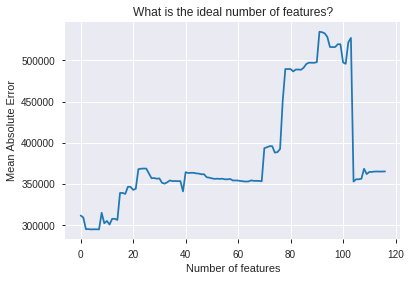

In [355]:
import matplotlib.pyplot as plt

maes = []
for k in range(1, len(X_train.columns)+1):
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)
  
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  
  maes.append(mean_absolute_error(y_test, y_pred))

plt.plot(np.arange(len(X_train.columns)), maes)
plt.xlabel('Number of features')
plt.ylabel('Mean Absolute Error')
plt.title('What is the ideal number of features?');

In [356]:
selector = SelectKBest(score_func=f_regression, k=8)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
selected_names

Index(['BOROUGH_1', 'BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS',
       'BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS', 'BLOCK',
       'BUILDING_CLASS_AT_PRESENT_D4', 'BUILDING_CLASS_AT_PRESENT_R4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_D4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_R4'],
      dtype='object')

### Do feature scaling.

In [357]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

train_scaled.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_1,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_UPPER WEST SIDE (79-96),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_FOREST HILLS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING_CLASS_CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_44 CONDO PARKING,BUILDING_CLASS_CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING_CLASS_CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING_CLASS_CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING_CLASS_CATEGORY_17 CONDO COOPS,BUILDING_CLASS_CATEGORY_29 COMMERCIAL GARAGES,BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING_CLASS_CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_27 FACTORIES,BUILDING_CLASS_CATEGORY_22 STORE BUILDINGS,BUILDING_CLASS_CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING_CLASS_CATEGORY_45 CONDO HOTELS,BUILDING_CLASS_CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING_CLASS_CATEGORY_14 RENTALS - 4-10 UNIT,...,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_OTHER,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_D4,BUILDING_CLASS_AT_TIME_OF_SALE_R4,BUILDING_CLASS_AT_TIME_OF_SALE_B2,BUILDING_CLASS_AT_TIME_OF_SALE_C0,BUILDING_CLASS_AT_TIME_OF_SALE_B1,BUILDING_CLASS_AT_TIME_OF_SALE_B3,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_C6,SALE_PRICE,SALE_DATE,STREET_OTHER,STREET_EAST 80TH STREET,STREET_81ST STREET,STREET_GRAND CENTRAL PARKWAY,STREET_EAST 22ND STREET,STREET_EAST 72ND STREET,STREET_WEST END AVENUE,STREET_RIVERSIDE DRIVE,STREET_BROADWAY,STREET_OCEAN PARKWAY,STREET_EAST 87TH STREET,STREET_PARK AVENUE,STREET_78TH STREET,STREET_OCEAN AVENUE,STREET_KENT AVENUE,STREET_108TH STREET,STREET_EAST 79TH STREET,STREET_CENTRAL PARK WEST,STREET_88TH STREET,STREET_EAST 19TH STREET,STREET_EAST 57TH STREET,STREET_35TH AVENUE,STREET_METROPOLITAN AVENUE,STREET_FIFTH AVENUE,STREET_95TH STREET
0,1.664076,-0.726310,-0.462434,-0.341912,-0.348866,0.425761,-0.135464,-0.116202,-0.103227,-0.132123,-0.11189,-0.174995,-0.089005,-0.134359,-0.098375,-0.132123,1.774348,-0.507836,-0.376618,-0.478088,-0.22694,-0.030974,-0.025911,-0.123605,-0.13837,-0.043826,-0.099364,-0.05718,-0.212313,-0.149472,-0.137287,-0.054591,-0.145056,-0.119546,-0.035321,-0.070088,-0.042714,-0.035321,-0.013847,-0.069394,...,0.200176,-0.819356,1.910311,-0.311167,-0.504100,-0.376618,-0.264879,-0.22694,-0.236357,-0.215984,-0.284457,-0.203788,-0.212066,-0.389418,-1.371706,0.362715,-0.040399,-0.040399,-0.05633,-0.048018,-0.045969,-0.079789,-0.059658,-0.062038,-0.061255,-0.04491,-0.05633,-0.049983,-0.055467,-0.045969,-0.042714,-0.047004,-0.048018,-0.041573,-0.050938,-0.041573,-0.045969,-0.040399,-0.050938,-0.041573
1,-0.600934,1.376823,-0.462434,-0.341912,-0.348866,0.425761,-0.135464,-0.116202,-0.103227,-0.132123,-0.11189,-0.174995,-0.089005,-0.134359,-0.098375,-0.132123,1.774348,-0.507836,-0.376618,-0.478088,-0.22694,-0.030974,-0.025911,-0.123605,-0.13837,-0.043826,-0.099364,-0.05718,-0.212313,-0.149472,-0.137287,-0.054591,-0.145056,-0.119546,-0.035321,-0.070088,-0.042714,-0.035321,-0.013847,-0.069394,...,0.222099,-0.819356,-0.523475,3.213706,-0.504100,-0.376618,-0.264879,-0.22694,-0.236357,-0.215984,-0.284457,-0.203788,-0.212066,-1.258383,-1.371706,0.362715,-0.040399,-0.040399,-0.05633,-0.048018,-0.045969,-0.079789,-0.059658,-0.062038,-0.061255,-0.04491,-0.05633,-0.049983,-0.

In [0]:
X_train = train_scaled.drop('SALE_PRICE', axis=1)
y_train = train_scaled['SALE_PRICE']

X_test = test_scaled.drop('SALE_PRICE', axis=1)
y_test = test_scaled['SALE_PRICE']

In [359]:
model = LinearRegression()
model.fit(X_train, y_train)
mean_absolute_error(y_test, model.predict(X_test))

17699148962306.875

### Fit a ridge regression model with multiple features.
### Get mean absolute error for the test set.

In [360]:
from sklearn.linear_model import Ridge

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mae = mean_absolute_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mae)

0 52685315817760.28
1 0.856904533319546
2 0.8476625735419557
3 0.8433656868077382
4 0.8408774254119136
5 0.8391306711898285
6 0.8377916776139434
7 0.8367809138295833
8 0.835964214487622
9 0.8352692630501658
10 0.8346631046500328
11 0.8341426233514582
12 0.8336954050548137
13 0.8332979729980919
14 0.8329626612246334
15 0.832662552802344
16 0.832396202056176
17 0.8321641733262074
18 0.8319687293094398
19 0.8317975429826598
20 0.8316436286017521
21 0.8315090704283689
22 0.8313871469595396
23 0.8312799659117431
24 0.8311818828290055
25 0.831101500724032
26 0.8310326999296069
27 0.8309698457752747
28 0.8309172138193404
29 0.8308735145759394
30 0.8308370571915177
31 0.8308109000757415
32 0.8307881269744002
33 0.8307678613151818
34 0.8307497080637181
35 0.8307354728366149
36 0.8307255171830171
37 0.8307185547581477
38 0.830715708845266
39 0.8307139661722321
40 0.8307132102756404
41 0.8307134122327137
42 0.8307152964345471
43 0.8307197523983744
44 0.8307247179676348
45 0.8307303607372983
46 0.

In [0]:
alphas = []
maes = []
for alpha in range(0, 1000, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mae = mean_absolute_error(y_test, ridge_reg_split.predict(X_test))
  alphas.append(alpha)
  maes.append(mae)

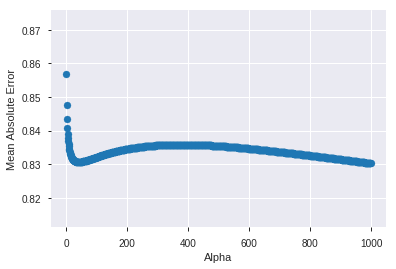

In [363]:
%matplotlib inline
plt.scatter(alphas[1:], maes[1:])
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error');

# Is it bad that it curves up and then down again?